In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import resample
import joblib


In [3]:
# Load dataset
tank_data = pd.read_csv("Tank_Water_Storage.csv")

Data Preprocessing

In [4]:
# Inspecting the data
print(tank_data.head())
print(tank_data.info())
print(tank_data.describe())

   Year    Month         Range  Storage (%)
0  2024  January        Ampara         91.5
1  2024  January  Anuradhapura        100.0
2  2024  January       Badulla         99.3
3  2024  January     Batticalo         88.4
4  2024  January    Hambantota         91.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         455 non-null    int64  
 1   Month        455 non-null    object 
 2   Range        455 non-null    object 
 3   Storage (%)  455 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 14.3+ KB
None
              Year  Storage (%)
count   455.000000   455.000000
mean   2022.971429    66.538022
std       0.811032    23.045230
min    2022.000000     4.300000
25%    2022.000000    48.200000
50%    2023.000000    69.000000
75%    2024.000000    86.450000
max    2024.000000   100.000000


In [ ]:
# Check for Missing values
print("Checking for NaN values after encoding:")
print(tank_data.isnull().sum())

# Optionally: Fill or drop missing values (if any)
#df = df.dropna() 

Checking for NaN values after encoding:
Year           0
Month          0
Range          0
Storage (%)    0
dtype: int64


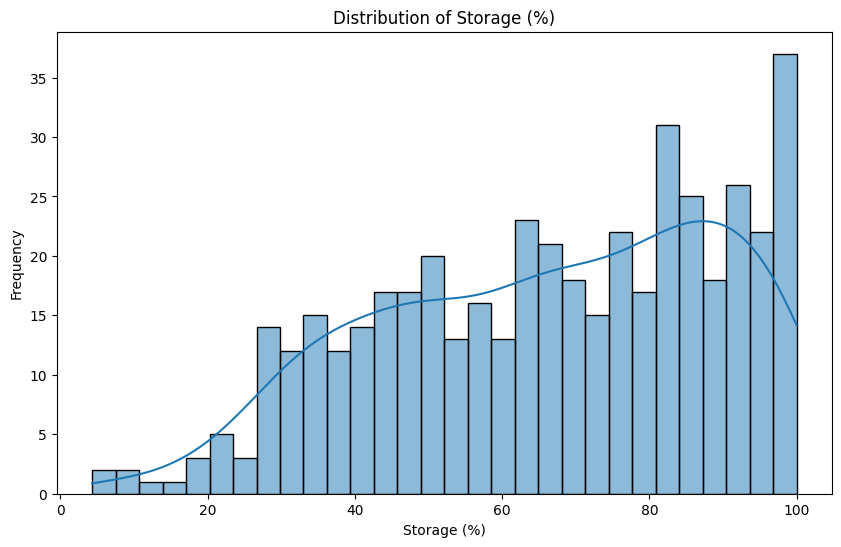

In [30]:
# Visualize the distribution of the target variable (Storage %)
plt.figure(figsize=(10, 6))
sns.histplot(tank_data['Storage (%)'], kde=True, bins=30)
plt.title('Distribution of Storage (%)')
plt.xlabel('Storage (%)')
plt.ylabel('Frequency')
plt.show()


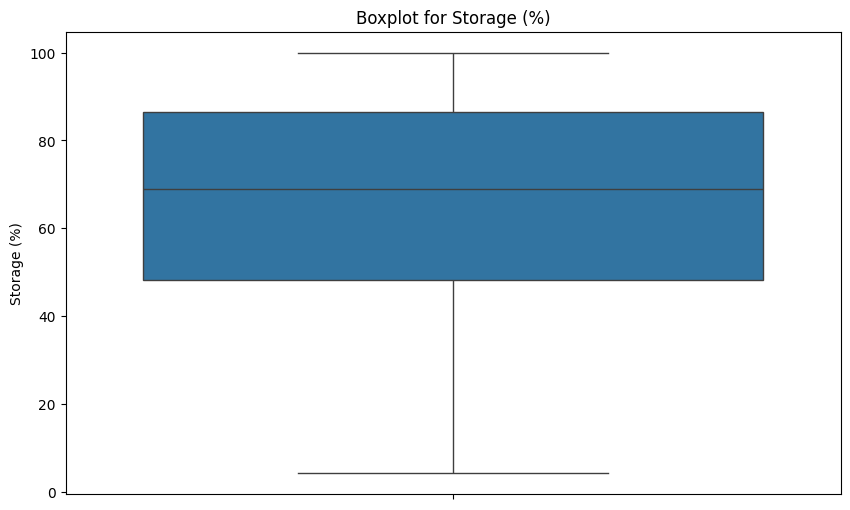

In [31]:
# Boxplot for outliers detection
plt.figure(figsize=(10, 6))
sns.boxplot(tank_data['Storage (%)'])
plt.title('Boxplot for Storage (%)')
plt.show()


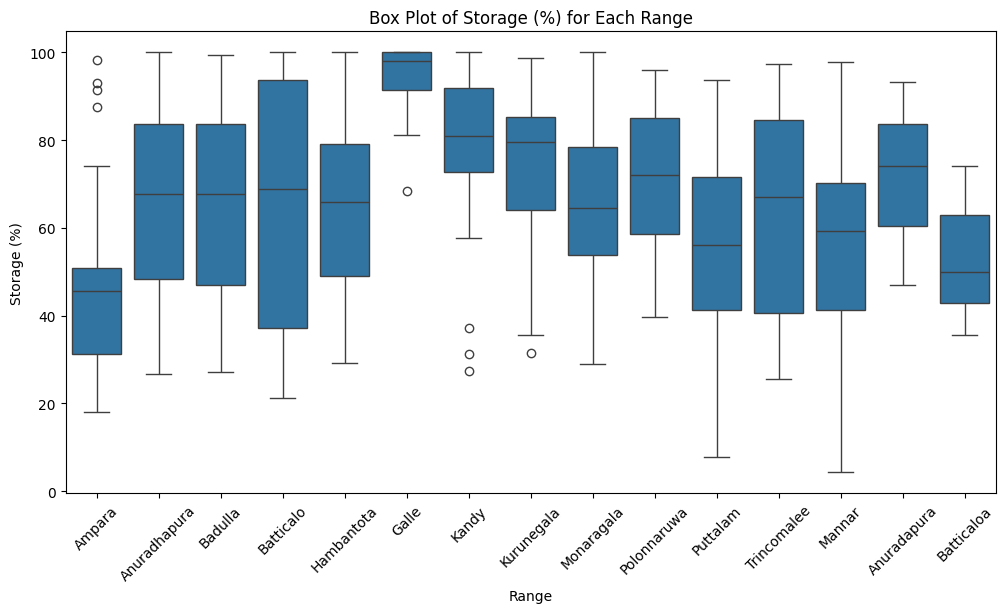

In [3]:
plt.figure(figsize=(12, 6))  # Increase figure size if needed
sns.boxplot(x='Range', y='Storage (%)', data=tank_data)
plt.title('Box Plot of Storage (%) for Each Range')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

In [32]:
from scipy.stats import zscore

tank_data['z_score'] = zscore(tank_data['Storage (%)'])

# Set a threshold for identifying outliers (Z-score > 3 or < -3)
threshold = 3

# Identify the outliers
outliers = tank_data[abs(tank_data['z_score']) > threshold]

# Print the outliers
print("Outliers based on Z-score:")
print(outliers)

Outliers based on Z-score:
Empty DataFrame
Columns: [Year, Month, Range, Storage (%), z_score]
Index: []


In [5]:
# Encode 'Month' and 'Range' using LabelEncoder
label_encoder_month = LabelEncoder()
label_encoder_range = LabelEncoder()

tank_data['Month'] = label_encoder_month.fit_transform(tank_data['Month'])
tank_data['Range'] = label_encoder_range.fit_transform(tank_data['Range'])

# Save the encoders for later use
joblib.dump(label_encoder_month, "water_encoder_month.pkl")
joblib.dump(label_encoder_range, "water_encoder_range.pkl")


['water_encoder_range.pkl']

In [6]:
# Normalize the target variable
scaler = MinMaxScaler()
y = tank_data[['Storage (%)']].values
y_scaled = scaler.fit_transform(y)

# Save the scaler for later use
joblib.dump(scaler, "storage_scaler.pkl")


['storage_scaler.pkl']

In [14]:
# Prepare input features (X) for the model
X = tank_data[['Month', 'Range']].values
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape for LSTM input

# Split the dataset into training (70%), testing+validation (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_scaled, test_size=0.3, random_state=42)

# Split the 30% into validation (20%) and testing (80%) of the 30%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

# Print the shapes of the splits
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (318, 1, 2) (318, 1)
Validation data shape: (27, 1, 2) (27, 1)
Testing data shape: (110, 1, 2) (110, 1)


In [15]:
# Define LSTM model architecture
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(1, X.shape[2]), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    LSTM(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(32, activation='relu'),  
    Dense(1)  # Output layer with no activation (for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model.summary()


f:\Softwares\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Define early stopping with increased patience
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=20,           # Increase patience to 20 epochs
    min_delta=0.001,       # Set a small change threshold to consider improvement
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 1.9559 - mae: 0.5595 - val_loss: 1.2334 - val_mae: 0.2896
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1069 - mae: 0.2954 - val_loss: 0.7660 - val_mae: 0.2551
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6804 - mae: 0.2641 - val_loss: 0.4745 - val_mae: 0.2319
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4268 - mae: 0.2457 - val_loss: 0.3048 - val_mae: 0.2308
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2780 - mae: 0.2385 - val_loss: 0.2064 - val_mae: 0.2284
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1870 - mae: 0.2243 - val_loss: 0.1517 - val_mae: 0.2307
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1340 - mae: 0.2088 - val_loss: 0.1200 - val_mae: 0.2277
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1075 - mae: 0.2088 - val_loss: 0.1038 - val_mae: 0.2282
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - l

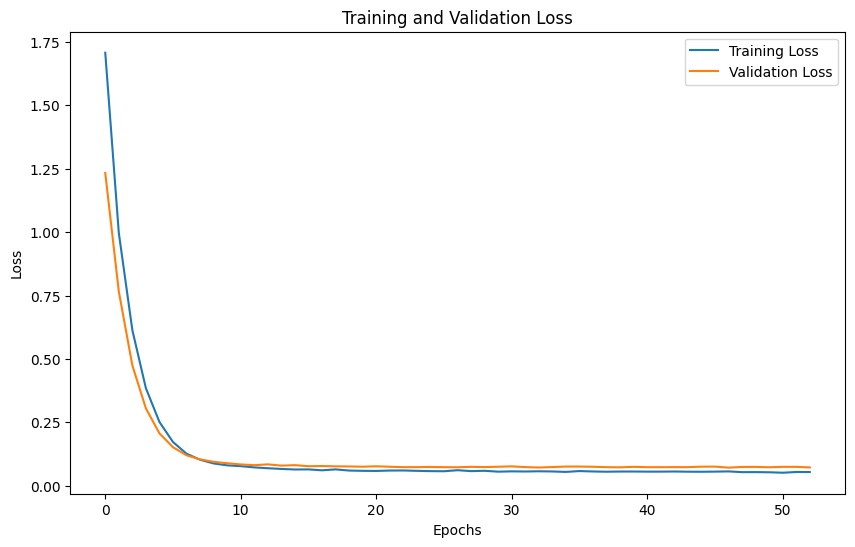

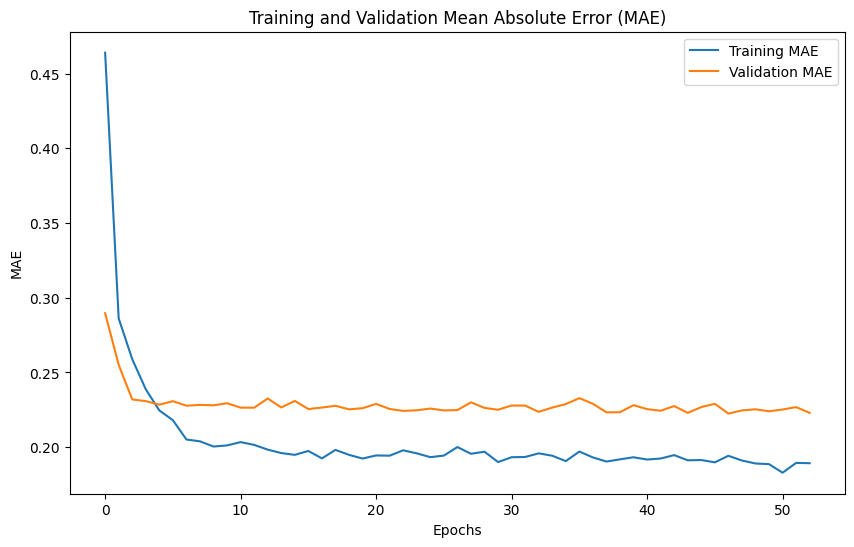

In [55]:
# Plot loss and accuracy curves
# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [56]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0492 - mae: 0.1849
Test Loss: [0.05118383839726448, 0.18874192237854004]


In [57]:
# Save the trained model for later use in the Flask app
model.save("lstm_tank_storage.h5")


In [58]:
# Save the scaler and encoders as pickle files
joblib.dump(scaler, "storage_scaler.pkl")
joblib.dump(label_encoder_month, "water_encoder_month.pkl")
joblib.dump(label_encoder_range, "water_encoder_range.pkl")


['water_encoder_range.pkl']

In [59]:
# Load the trained model
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model = load_model("lstm_tank_storage.h5", custom_objects={"mse": MeanSquaredError()})

# Load the scalers and encoders
scaler = joblib.load("storage_scaler.pkl")
label_encoder_month = joblib.load("water_encoder_month.pkl")
label_encoder_range = joblib.load("water_encoder_range.pkl")

# Example: Encode new input and make a prediction
month_encoded = label_encoder_month.transform(['April'])[0]
range_encoded = label_encoder_range.transform(['Anuradhapura'])[0]

sample_input = np.array([[month_encoded, range_encoded]]).reshape(1, 1, 2)
predicted_storage = model.predict(sample_input)
predicted_storage = scaler.inverse_transform(predicted_storage.reshape(-1, 1))

print(f"Predicted Storage (%) : {predicted_storage[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
Predicted Storage (%) : 72.52820587158203


In [60]:
print("Expected input range:", X_train.min(), X_train.max())
print("Expected target range before scaling:", y_train.min(), y_train.max())



Expected input range: 0 14
Expected target range before scaling: 0.0 1.0


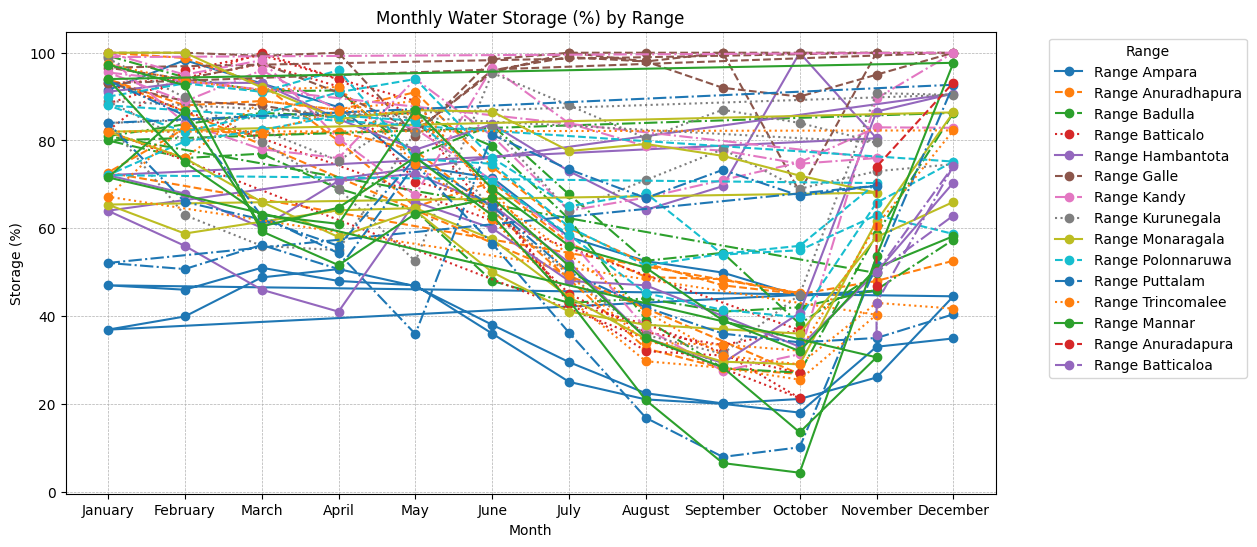

In [4]:
plt.figure(figsize=(12, 6))  # Bigger figure for better visibility
line_styles = ['-', '--', '-.', ':']  # Different line styles
colors = sns.color_palette('tab10', n_colors=len(tank_data['Range'].unique()))

for i, r in enumerate(tank_data['Range'].unique()):
    subset = tank_data[tank_data['Range'] == r]
    plt.plot(subset['Month'], subset['Storage (%)'], label=f'Range {r}',
             marker='o', linestyle=line_styles[i % len(line_styles)], color=colors[i])

plt.xlabel('Month')
plt.ylabel('Storage (%)')
plt.title('Monthly Water Storage (%) by Range')
plt.legend(title='Range', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend to the side
plt.grid(True, linestyle='--', linewidth=0.5)  # Add a grid for readability
plt.show()


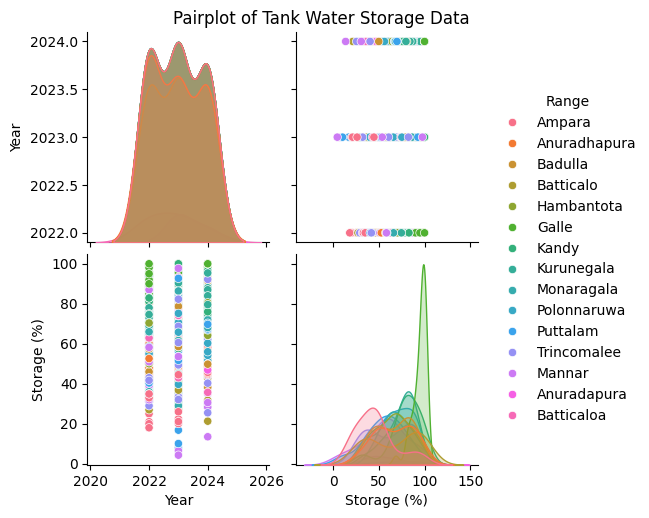

In [6]:
sns.pairplot(tank_data, hue='Range')
plt.suptitle('Pairplot of Tank Water Storage Data', y=1.02)
plt.show()

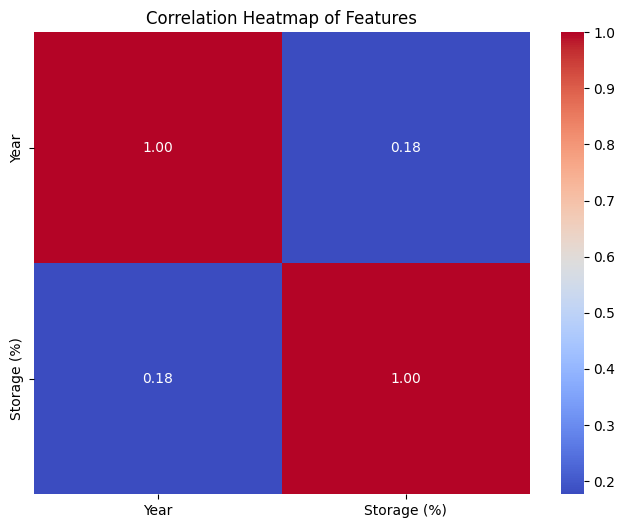

In [8]:
corr = tank_data[['Year', 'Storage (%)']].corr()  # Remove 'Range'
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

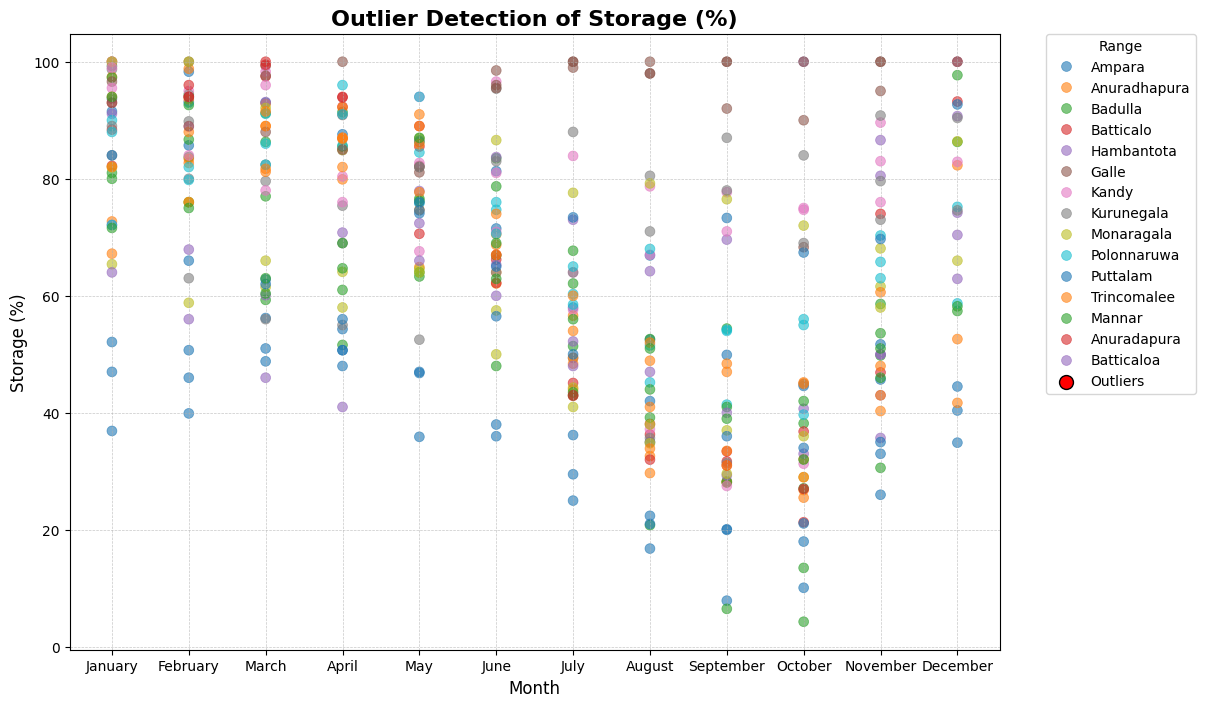

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the IQR and find outliers
Q1 = tank_data['Storage (%)'].quantile(0.25)
Q3 = tank_data['Storage (%)'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = tank_data[(tank_data['Storage (%)'] < (Q1 - 1.5 * IQR)) |
                     (tank_data['Storage (%)'] > (Q3 + 1.5 * IQR))]

# Plot
plt.figure(figsize=(12, 8))  # Increase figure size for better visibility

# Scatterplot for all points (make them semi-transparent)
sns.scatterplot(x='Month', y='Storage (%)', hue='Range', data=tank_data,
                palette='tab10', alpha=0.6, s=50, edgecolor=None)  # alpha for transparency, s for size

# Highlight outliers as large red points
plt.scatter(outliers['Month'], outliers['Storage (%)'],
            color='red', s=100, edgecolor='black', label='Outliers')  # Larger red points with black border

# Improve plot labels, title, and grid
plt.xlabel('Month', fontsize=12)
plt.ylabel('Storage (%)', fontsize=12)
plt.title('Outlier Detection of Storage (%)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for alignment

# Improve legend
plt.legend(title='Range', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  # Legend outside the plot

plt.show()
